# AI-Based Recipe Generator from Food Images

This project uses deep learning to classify an image of a food dish and then generates a recipe for it using an external API. The core of the project is a ResNet50 model fine-tuned on the Food-11 dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("--- Installing Libraries ---")
!pip install tensorflow googletrans==4.0.0-rc1 requests -q

print("\n--- Unzipping Dataset from Google Drive ---")
# This command finds 'food-11.zip' in your main Drive folder and extracts it.
!unzip /content/drive/MyDrive/food-11.zip -d /content/

print("\n✅ Setup Complete. Dataset is ready in '/content/food-11/'.")

Streaming output truncated to the last 5000 lines.
  inflating: /content/food-11/training/Soup/237.jpg  
  inflating: /content/food-11/training/Soup/238.jpg  
  inflating: /content/food-11/training/Soup/239.jpg  
  inflating: /content/food-11/training/Soup/24.jpg  
  inflating: /content/food-11/training/Soup/240.jpg  
  inflating: /content/food-11/training/Soup/241.jpg  
  inflating: /content/food-11/training/Soup/242.jpg  
  inflating: /content/food-11/training/Soup/243.jpg  
  inflating: /content/food-11/training/Soup/244.jpg  
  inflating: /content/food-11/training/Soup/245.jpg  
  inflating: /content/food-11/training/Soup/246.jpg  
  inflating: /content/food-11/training/Soup/247.jpg  
  inflating: /content/food-11/training/Soup/248.jpg  
  inflating: /content/food-11/training/Soup/249.jpg  
  inflating: /content/food-11/training/Soup/25.jpg  
  inflating: /content/food-11/training/Soup/250.jpg  
  inflating: /content/food-11/training/Soup/251.jpg  
  inflating: /content/food-11/tra

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 9866 training images and 3430 validation images.

--- STAGE 1: Training the top layers ---
Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 180s 537ms/step - accuracy: 0.1812 - loss: 2.4086 - val_accuracy: 0.2041 - val_loss: 2.1937 - learning_rate: 0.0010
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 145s 470ms/step - accuracy: 0.2304 - loss: 2.1830 - val_accuracy: 0.2222 - val_loss: 2.1448 - learning_rate: 0.0010
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 140s 455ms/step - accuracy: 0.2389 - loss: 2.1604 - val_accuracy: 0.2542 - val_loss: 2.1227 - learning_rate: 0.0010
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 141s 451ms/step - accuracy: 0.2405 - loss: 2.1413 - val_accuracy: 0.2122 - val_loss: 2.1617 - learning_rate: 0.0010
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 141s 456ms/step - accuracy: 0.2456 - loss: 2.1329 - val_accuracy: 0.2469 - val_loss: 2.1185 - learning_rate: 0.0010
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━


✅ Optimized model successfully trained and saved to /content/drive/MyDrive/food_11_best_model.h5


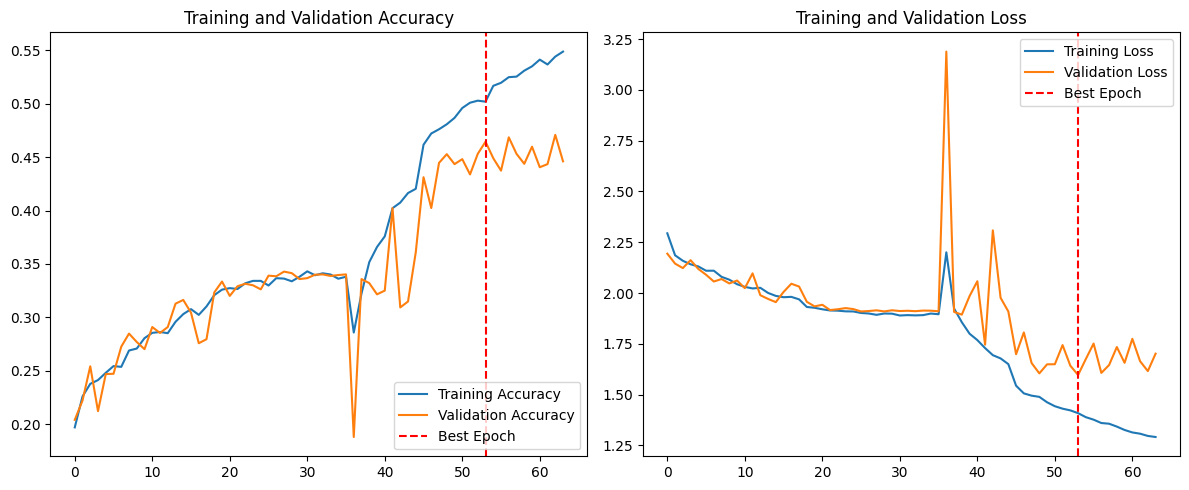

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
TRAINING_PATH = '/content/food-11/training'
VALIDATION_PATH = '/content/food-11/validation'
MODEL_SAVE_PATH = '/content/drive/MyDrive/food_11_best_model.h5'

# --- 1. Create Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAINING_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

num_classes = train_generator.num_classes
print(f"Found {train_generator.samples} training images and {validation_generator.samples} validation images.")

# --- 2. Build the Model ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# --- 3. Initial Training (Top Layers Only) ---
print("\n--- STAGE 1: Training the top layers ---")
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# --- 4. Fine-Tuning Stage ---
print("\n--- STAGE 2: Fine-tuning the model ---")
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# --- 5. Save Final Model and Plot ---
model.save(MODEL_SAVE_PATH)
print(f"\n✅ Optimized model successfully trained and saved to {MODEL_SAVE_PATH}")

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
if val_loss: plt.axvline(np.argmin(val_loss), color='r', linestyle='--', label='Best Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
if val_loss: plt.axvline(np.argmin(val_loss), color='r', linestyle='--', label='Best Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

In [ ]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=4e80cfd55c5b1ec6cfa36c1e86b8a58d17ceac52848412f4cb2f87037b9c64c8
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

--- Loading trained model and class names ---


Found 9866 images belonging to 11 classes.
✅ Model and class names loaded.

Please upload a food image...


Saving WhatsApp Image 2025-08-19 at 13.33.21_d3199019.jpg to WhatsApp Image 2025-08-19 at 13.33.21_d3199019 (1).jpg


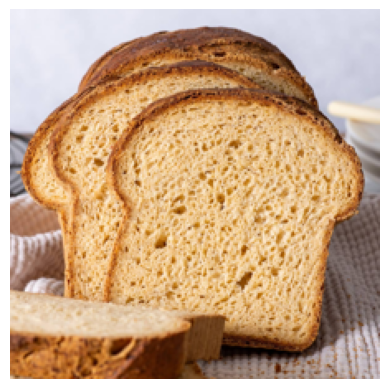

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Predicted dish: 'Vegetable-Fruit' with 47.26% confidence.

Enter your preferred language code (e.g., es, fr, de) or press Enter for English: 

**Bird Cakes**

**Ingredients (Translated to en):**

**Instructions (Translated to en):**
Instructions not available.


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # <-- THIS LINE WAS ADDED
import PIL.Image
import io
import matplotlib.pyplot as plt
from google.colab import files
import requests
from googletrans import Translator

# --- Configuration ---
# Make sure this path matches the model you saved
MODEL_PATH = '/content/drive/MyDrive/food_11_best_model.h5'
# !!! IMPORTANT: Replace with your actual Spoonacular API key
API_KEY = "9e51bc6964d942b1b35e37a2d9517ede"
# This path is needed to get the class names in the correct order
TRAINING_PATH = '/content/food-11/training'

# --- 1. Load Model and Class Names ---
print("--- Loading trained model and class names ---")
# Unzip the data again if the session restarted and the folder is missing
import os
if not os.path.exists(TRAINING_PATH):
    print("Dataset not found, unzipping from Drive again...")
    !unzip -q /content/drive/MyDrive/food-11.zip -d /content/

model = tf.keras.models.load_model(MODEL_PATH)

datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(
    TRAINING_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_names = {v: k for k, v in data_generator.class_indices.items()}
print("✅ Model and class names loaded.")

# --- 2. Define Helper Functions ---
def fetch_recipe(dish_name, api_key):
    url = "https://api.spoonacular.com/recipes/complexSearch"
    clean_dish_name = dish_name.replace("_", " ")
    params = {"query": clean_dish_name, "apiKey": api_key, "number": 1, "addRecipeInformation": True}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if data.get("results"):
            details = data["results"][0]
            return {
                "title": details.get("title", "No Title"),
                "ingredients": [ing["original"] for ing in details.get("extendedIngredients", [])],
                "instructions": details.get("instructions", "Instructions not available."),
            }
        else:
            return f"Recipe not found for '{clean_dish_name}'."
    except requests.exceptions.RequestException as e:
        return f"API Error: {e}"

def format_and_translate_recipe(recipe, target_language):
    if isinstance(recipe, str):
        return recipe
    translator = Translator()
    try:
        translated_title = translator.translate(recipe['title'], dest=target_language).text
        translated_ingredients = [translator.translate(ing, dest=target_language).text for ing in recipe['ingredients']]
        translated_instructions = translator.translate(recipe['instructions'], dest=target_language).text
    except Exception as e:
        return f"Translation failed: {e}"

    formatted = f"**{translated_title}**\n\n"
    formatted += f"**Ingredients (Translated to {target_language}):**\n"
    for ingredient in translated_ingredients:
        formatted += f"- {ingredient}\n"
    formatted += f"\n**Instructions (Translated to {target_language}):**\n"
    clean_instructions = translated_instructions.replace("<ol>", "").replace("</ol>", "").replace("<li>", "- ").replace("</li>", "\n")
    formatted += clean_instructions
    return formatted.strip()

# --- 3. Main execution block ---
def run_recipe_generator():
    print("\nPlease upload a food image...")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return

    img_name = list(uploaded.keys())[0]

    img = PIL.Image.open(io.BytesIO(uploaded[img_name])).convert('RGB').resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_names[predicted_index]
    confidence = 100 * np.max(predictions[0])
    print(f"✅ Predicted dish: '{predicted_label.replace('_', ' ').title()}' with {confidence:.2f}% confidence.")

    recipe_data = fetch_recipe(predicted_label, API_KEY)

    user_language = input("\nEnter your preferred language code (e.g., es, fr, de) or press Enter for English: ").strip().lower()
    if not user_language:
        user_language = 'en'

    translated_recipe = format_and_translate_recipe(recipe_data, user_language)
    print("\n" + "="*30)
    print(translated_recipe)
    print("="*30)

# --- Run the application ---
run_recipe_generator()